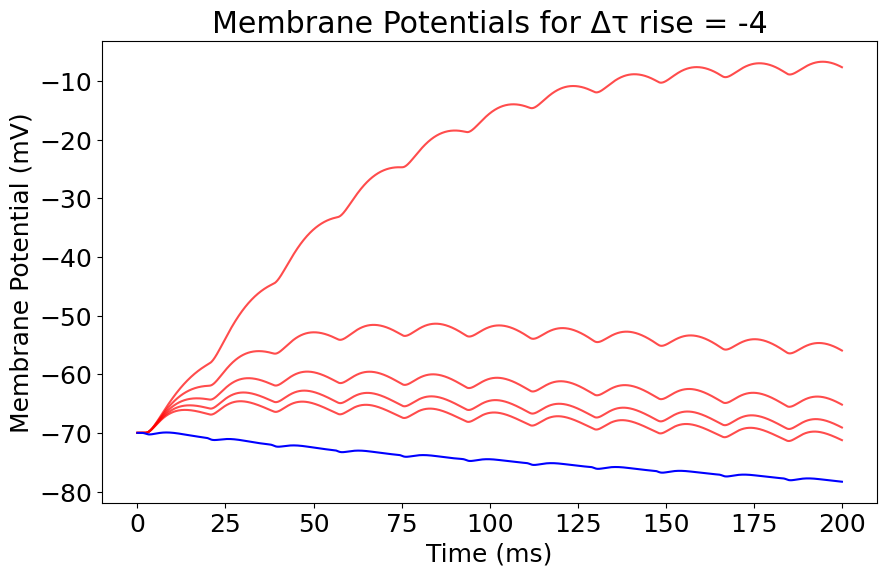

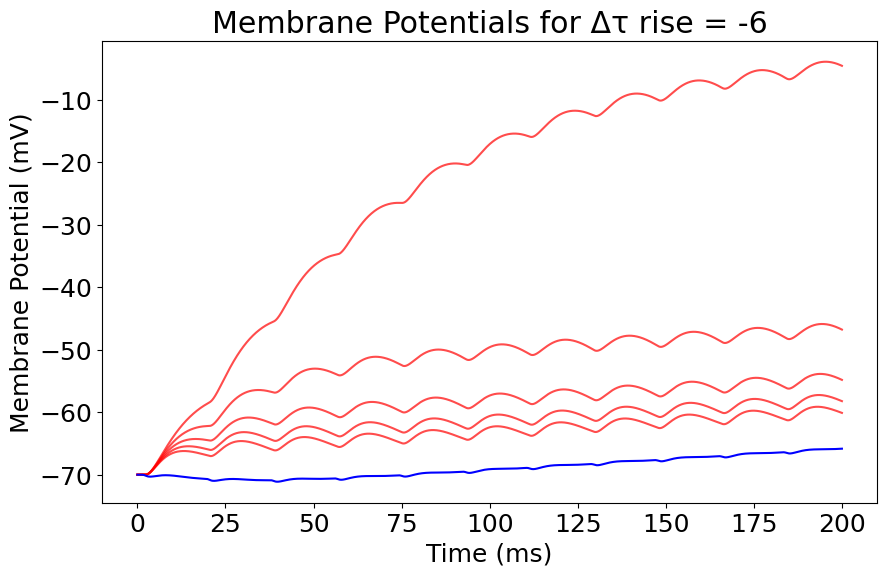

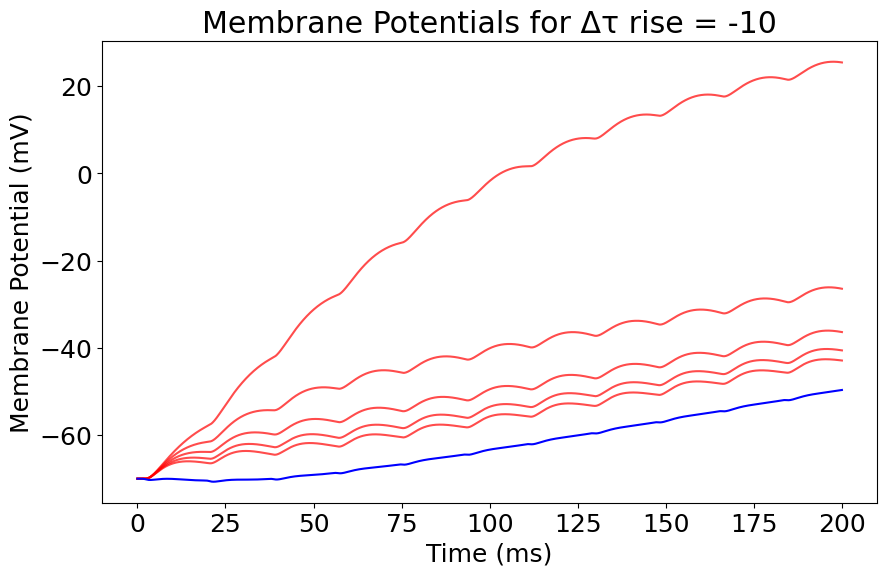

In [5]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 18})

def calculate_rmse(signal1, signal2):
    return np.sqrt(np.mean((np.array(signal1) - np.array(signal2)) ** 2))

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"

delay = 0
width_block = 1
frequency = 120  # Hz

g_coupling_values = np.linspace(0.01, 0.1, 5)

# Define tau_1 and tau_1g pairs to achieve desired Δτ rise values
tau_pairs = [(16, 20), (12, 18), (15, 25)]  # (tau_1, tau_1g) pairs for Δτ rise = -4, -6, -10

for tau_1, tau_1g in tau_pairs:
    plt.figure(figsize=(10, 6))

    for g_coupling in g_coupling_values:
        t = 200
        dt = 0.1
        N = round(t / dt)
        ttotal = np.arange(0, t, dt)

        # Signal generation
        tspks = np.linspace(0, t, int(frequency / 10))
        tspksi = [int(x / dt) for x in tspks]
        tspksf = [int((x + width_block) / dt) for x in tspks]
        amp = 1
        syn = np.zeros_like(ttotal)
        for i in range(len(tspksi)):
            syn[tspksi[i]:tspksf[i]] = amp

        lat_e = 1
        syn_ampa = np.zeros_like(ttotal)
        for o in range(len(tspksi)):
            syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1

        lat_i = 2
        syn_gaba = np.zeros_like(ttotal)
        for o in range(len(tspksi)):
            syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1

        # Initialize variables
        s_AMPA = 0
        x_ampa = 0
        s_GABA = 0
        x_gaba = 0

        tau_2 = 5 #ms
        tau_2g = 2 #ms

        Iacum_AMPA = []
        Iacum_GABA = []
        IacumCo = []

        v_soma = -70
        v_dend = -70
        gleak_soma = 1 * (10 ** -4)
        gleak_dend = 1 * (10 ** -4)
        Eleak_soma = -70
        Eleak_dend = -70
        vacum_soma = []
        vacum_dend = []

        v_soma2 = -70
        v_dend2 = -70
        vacum_soma2 = []
        vacum_dend2 = []

        # Simulation loop
        for i in range(N):
            s_AMPA = s_AMPA + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA) / tau_1)
            x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn_ampa[i])
            Iacum_AMPA.append(-s_AMPA)

            s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
            x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn_gaba[i])
            Iacum_GABA.append(s_GABA)

            IacumCo.append(s_GABA - s_AMPA)

            Ileak_soma = gleak_soma * (v_soma - Eleak_soma)
            Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
            I_coupling = g_coupling * (v_soma - v_dend)

            I_total_soma = -Ileak_soma - I_coupling + IacumCo[-1]
            I_total_dend = -Ileak_dend + I_coupling

            v_soma = v_soma + dt * I_total_soma
            v_dend = v_dend + dt * I_total_dend

            vacum_soma.append(v_soma)
            vacum_dend.append(v_dend)

            Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
            Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
            I_coupling = g_coupling * (v_soma2 - v_dend2)
            I_total_soma = -Ileak_soma - I_coupling + Iacum_GABA[-1]
            I_total_dend = -Ileak_dend + I_coupling + Iacum_AMPA[-1]

            v_soma2 = v_soma2 + dt * I_total_soma
            v_dend2 = v_dend2 + dt * I_total_dend

            vacum_soma2.append(v_soma2)
            vacum_dend2.append(v_dend2)

        # Plot membrane potentials
        plt.plot(ttotal, vacum_soma2, c='r', alpha=0.7)  # Synaptic Transmission in red

    plt.plot(ttotal, vacum_soma, label='Co-transmission', c='b')

    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title(f'Membrane Potentials for Δτ rise = {tau_1 - tau_1g}')
    plt.show()

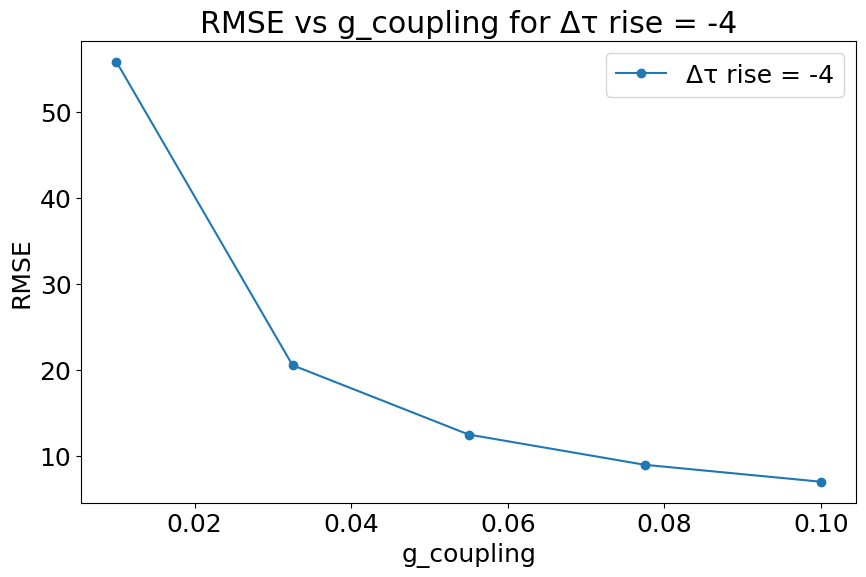

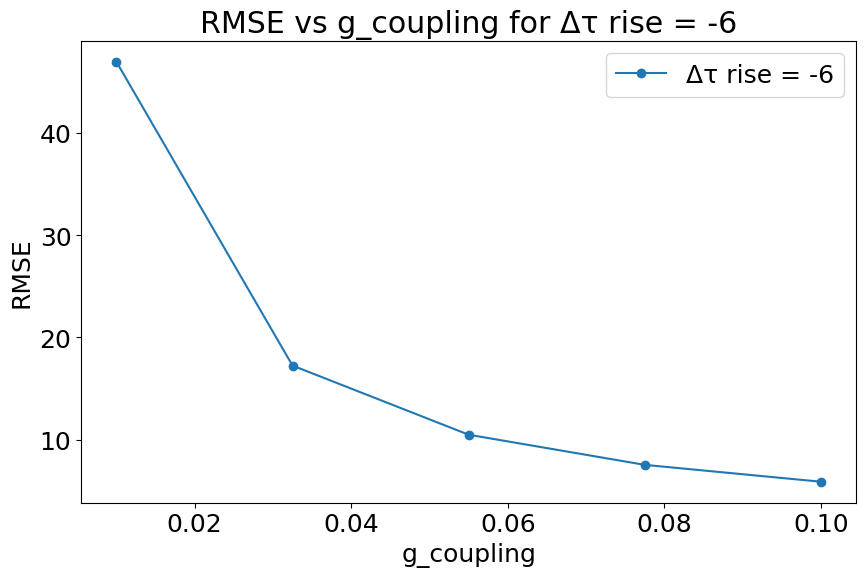

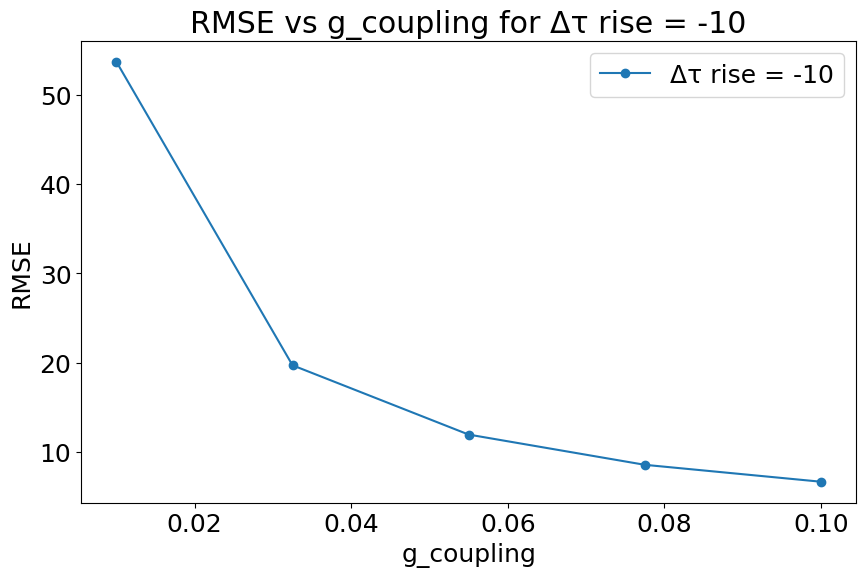

In [4]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 18})

def calculate_rmse(signal1, signal2):
    return np.sqrt(np.mean((np.array(signal1) - np.array(signal2)) ** 2))

# Simulation parameters
delay = 0
width_block = 1
frequency = 120  # Hz
t = 200
dt = 0.1
N = round(t / dt)
ttotal = np.arange(0, t, dt)

# Adjusted Tau values to achieve desired Δτ rise values
tau_1_values = [16, 12, 15]  # Example values for tau_1
tau_1g_values = [20, 18, 25]  # Example values for tau_1g

# g_coupling values to test
g_coupling_values = np.linspace(0.01, 0.1, 5)  # Example range for g_coupling

# Store RMSE results
rmse_results = {}

# Loop over different tau_1, tau_1g, and g_coupling values
for tau_1 in tau_1_values:
    for tau_1g in tau_1g_values:
        delta_tau_rise = tau_1 - tau_1g
        if delta_tau_rise in [-4, -6, -10]:  # Only store desired Δτ rise values
            if delta_tau_rise not in rmse_results:
                rmse_results[delta_tau_rise] = []

            for g_coupling in g_coupling_values:
                # Initialize variables
                s_AMPA = 0
                x_ampa = 0
                s_GABA = 0
                x_gaba = 0

                tau_2 = 5 #ms
                tau_2g = 2 #ms

                Iacum_AMPA = []
                Iacum_GABA = []
                IacumCo = []

                v_soma = -70
                v_dend = -70
                gleak_soma = 1 * (10 ** -4)
                gleak_dend = 1 * (10 ** -4)
                Eleak_soma = -70
                Eleak_dend = -70
                vacum_soma = []
                vacum_dend = []

                v_soma2 = -70
                v_dend2 = -70
                vacum_soma2 = []
                vacum_dend2 = []

                # Generate synaptic signals
                tspks = np.linspace(0, t, int(frequency / 10))
                tspksi = [int(x / dt) for x in tspks]
                tspksf = [int((x + width_block) / dt) for x in tspks]
                amp = 1
                syn = np.zeros_like(ttotal)
                for i in range(len(tspksi)):
                    syn[tspksi[i]:tspksf[i]] = amp

                lat_e = 1
                syn_ampa = np.zeros_like(ttotal)
                for o in range(len(tspksi)):
                    syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1

                lat_i = 2
                syn_gaba = np.zeros_like(ttotal)
                for o in range(len(tspksi)):
                    syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1

                # Simulation loop
                for i in range(N):
                    s_AMPA = s_AMPA + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA) / tau_1)
                    x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn_ampa[i])
                    Iacum_AMPA.append(-s_AMPA)

                    s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
                    x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn_gaba[i])
                    Iacum_GABA.append(s_GABA)

                    IacumCo.append(s_GABA - s_AMPA)

                    Ileak_soma = gleak_soma * (v_soma - Eleak_soma)
                    Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
                    I_coupling = g_coupling * (v_soma - v_dend)

                    I_total_soma = -Ileak_soma - I_coupling + IacumCo[-1]
                    I_total_dend = -Ileak_dend + I_coupling

                    v_soma = v_soma + dt * I_total_soma
                    v_dend = v_dend + dt * I_total_dend

                    vacum_soma.append(v_soma)
                    vacum_dend.append(v_dend)

                    Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
                    Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
                    I_coupling = g_coupling * (v_soma2 - v_dend2)
                    I_total_soma = -Ileak_soma - I_coupling + Iacum_GABA[-1]
                    I_total_dend = -Ileak_dend + I_coupling + Iacum_AMPA[-1]

                    v_soma2 = v_soma2 + dt * I_total_soma
                    v_dend2 = v_dend2 + dt * I_total_dend

                    vacum_soma2.append(v_soma2)
                    vacum_dend2.append(v_dend2)

                # Calculate RMSE
                vacum_soma = np.array(vacum_soma)
                vacum_soma2 = np.array(vacum_soma2)
                rmse = calculate_rmse(vacum_soma, vacum_soma2)

                # Store RMSE for this g_coupling
                rmse_results[delta_tau_rise].append(rmse)

for delta_tau_rise, rmse_values in rmse_results.items():
    plt.figure(figsize=(10, 6))
    plt.plot(g_coupling_values, rmse_values, marker='o', label=f'Δτ rise = {delta_tau_rise}')
    plt.xlabel('g_coupling')
    plt.ylabel('RMSE')
    plt.title(f'RMSE vs g_coupling for Δτ rise = {delta_tau_rise}')
    plt.legend()
    plt.show()

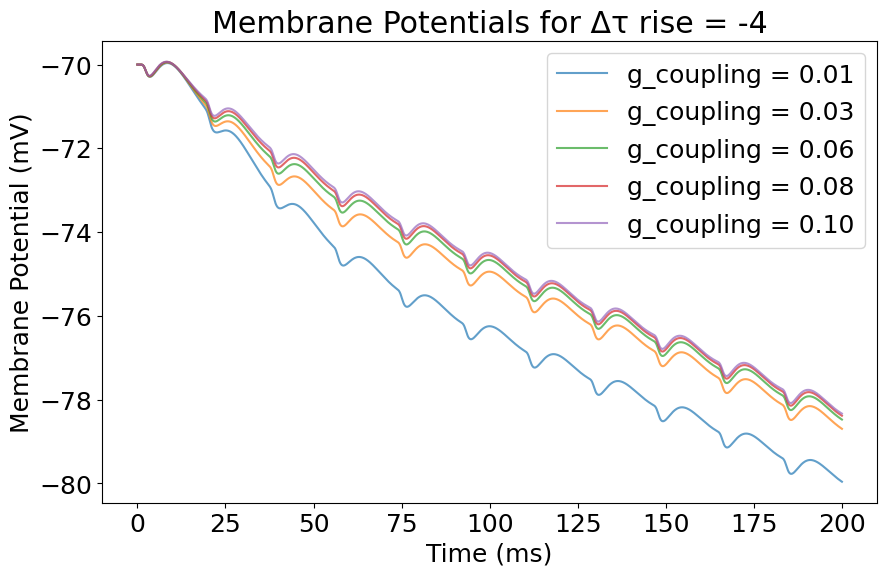

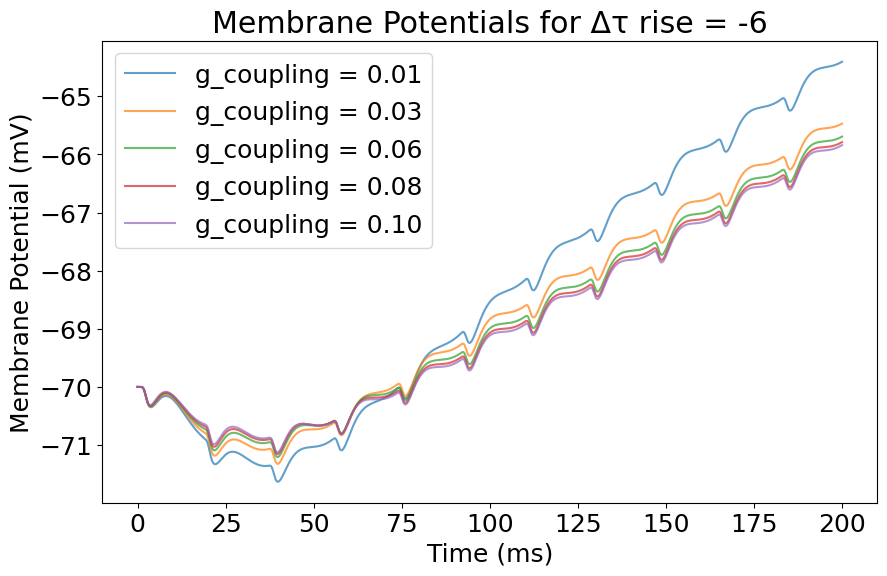

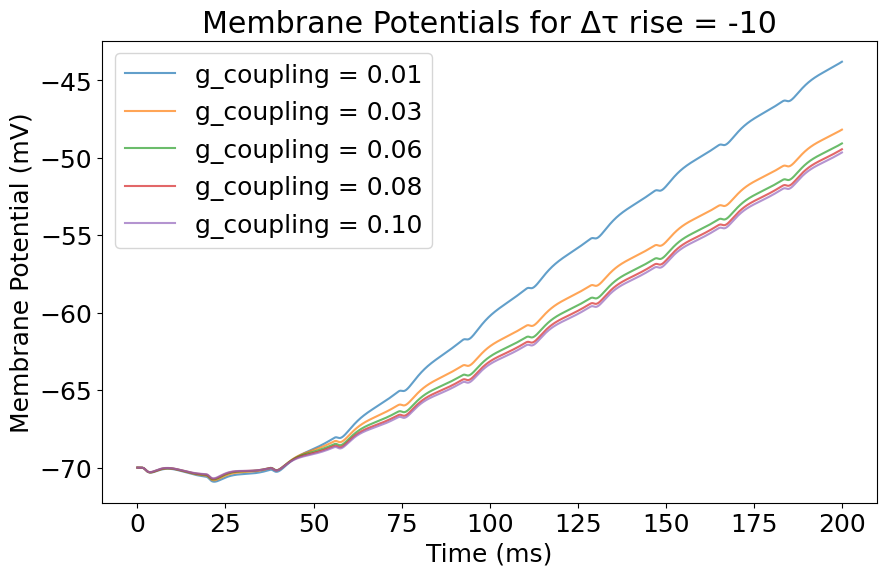

In [6]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.ndimage import gaussian_filter1d
from scipy.signal import find_peaks

plt.rcParams.update({'font.size': 18})

def calculate_rmse(signal1, signal2):
    return np.sqrt(np.mean((np.array(signal1) - np.array(signal2)) ** 2))

def signal_trend(data):
    if np.argmin(data) > len(data)-3:
        return "decreasing"
    elif np.argmin(data) < 3:
        return "increasing"
    else:
        return "peaking"

delay = 0
width_block = 1
frequency = 120  # Hz

g_coupling_values = np.linspace(0.01, 0.1, 5)

# Define tau_1 and tau_1g pairs to achieve desired Δτ rise values
tau_pairs = [(16, 20), (12, 18), (15, 25)]  # (tau_1, tau_1g) pairs for Δτ rise = -4, -6, -10

for tau_1, tau_1g in tau_pairs:
    plt.figure(figsize=(10, 6))

    for g_coupling in g_coupling_values:
        t = 200
        dt = 0.1
        N = round(t / dt)
        ttotal = np.arange(0, t, dt)

        # Signal generation
        tspks = np.linspace(0, t, int(frequency / 10))
        tspksi = [int(x / dt) for x in tspks]
        tspksf = [int((x + width_block) / dt) for x in tspks]
        amp = 1
        syn = np.zeros_like(ttotal)
        for i in range(len(tspksi)):
            syn[tspksi[i]:tspksf[i]] = amp

        lat_e = 1
        syn_ampa = np.zeros_like(ttotal)
        for o in range(len(tspksi)):
            syn_ampa[int(tspksi[o] + int(lat_e / dt)):int(tspksf[o] + int(lat_e / dt))] = 1

        lat_i = 2
        syn_gaba = np.zeros_like(ttotal)
        for o in range(len(tspksi)):
            syn_gaba[int(tspksi[o] + int(lat_i / dt)):int(tspksf[o] + int(lat_i / dt))] = 1

        # Initialize variables
        s_AMPA = 0
        x_ampa = 0
        s_GABA = 0
        x_gaba = 0

        Iacum_AMPA = []
        Iacum_GABA = []
        IacumCo = []

        v_soma = -70
        v_dend = -70
        gleak_soma = 1 * (10 ** -4)
        gleak_dend = 1 * (10 ** -4)
        Eleak_soma = -70
        Eleak_dend = -70
        vacum_soma = []
        vacum_dend = []

        tau_2 = 5 #ms
        tau_2g = 2 #ms

        v_soma2 = -70
        v_dend2 = -70
        vacum_soma2 = []
        vacum_dend2 = []

        # Simulation loop
        for i in range(N):
            s_AMPA = s_AMPA + dt * (((tau_2 / tau_1) ** (tau_1 / (tau_2 - tau_1)) * x_ampa - s_AMPA) / tau_1)
            x_ampa = x_ampa + dt * (-x_ampa / tau_2 + syn_ampa[i])
            Iacum_AMPA.append(-s_AMPA)

            s_GABA = s_GABA + dt * (((tau_2g / tau_1g) ** (tau_1g / (tau_2g - tau_1g)) * x_gaba - s_GABA) / tau_1g)
            x_gaba = x_gaba + dt * (-x_gaba / tau_2g + syn_gaba[i])
            Iacum_GABA.append(s_GABA)

            IacumCo.append(s_GABA - s_AMPA)

            Ileak_soma = gleak_soma * (v_soma - Eleak_soma)
            Ileak_dend = gleak_dend * (v_dend - Eleak_dend)
            I_coupling = g_coupling * (v_soma - v_dend)

            I_total_soma = -Ileak_soma - I_coupling + IacumCo[-1]
            I_total_dend = -Ileak_dend + I_coupling

            v_soma = v_soma + dt * I_total_soma
            v_dend = v_dend + dt * I_total_dend

            vacum_soma.append(v_soma)
            vacum_dend.append(v_dend)

            Ileak_soma = gleak_soma * (v_soma2 - Eleak_soma)
            Ileak_dend = gleak_dend * (v_dend2 - Eleak_dend)
            I_coupling = g_coupling * (v_soma2 - v_dend2)
            I_total_soma = -Ileak_soma - I_coupling + Iacum_GABA[-1]
            I_total_dend = -Ileak_dend + I_coupling + Iacum_AMPA[-1]

            v_soma2 = v_soma2 + dt * I_total_soma
            v_dend2 = v_dend2 + dt * I_total_dend

            vacum_soma2.append(v_soma2)
            vacum_dend2.append(v_dend2)

        # Plot membrane potentials
        plt.plot(ttotal, vacum_soma, label=f'g_coupling = {g_coupling:.2f}', alpha=0.7)

    plt.xlabel('Time (ms)')
    plt.ylabel('Membrane Potential (mV)')
    plt.title(f'Membrane Potentials for Δτ rise = {tau_1 - tau_1g}')
    plt.legend()
    plt.show()